In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import random

from sales_forecasting.utils import timeseries_split
from sales_forecasting.plot import plot_timeseries, plot_feature_importance
from sales_forecasting.features import col_name

In [4]:
random.seed(42)
np.random.seed(42)

In [5]:
df = pd.read_parquet(".data/df_agg_monthly_oversampled.parquet")

In [6]:
train_split, valid_split = timeseries_split(df, max_month=33, col='date_block_num', continuous=False)
train_test_split, test_split = timeseries_split(df, max_month=34, col='date_block_num', continuous=False)

In [7]:
target_col = 'item_cnt_month'
train_target, valid_target = train_split[target_col].clip(0, 20), valid_split[target_col].clip(0, 20)

In [8]:
cols_to_drop = [target_col, 'date_block_num', 'shop_id', 'item_id']
X_train, X_valid = train_split.drop(columns=cols_to_drop), valid_split.drop(columns=cols_to_drop)

In [9]:
X_train.shape, X_valid.shape

((21137776, 29), (1242942, 29))

In [10]:
# sample_train = np.random.randint(0, X_train.shape[0]+1, 1000000)
# sample_valid = np.random.randint(0, X_valid.shape[0]+1, 100000)
# X_train, X_valid, train_target, valid_target = X_train.iloc[sample_train], X_valid.iloc[sample_valid], train_target.iloc[sample_train], valid_target.iloc[sample_valid]

In [11]:
def compute_metrics(y_true, y_pred):
    return {
        'rmse': float(metrics.root_mean_squared_error(y_true, y_pred)),
        'r2': float(metrics.r2_score(y_true, y_pred)),
        'mae': float(metrics.mean_absolute_error(y_true, y_pred))
    }

# Naive model

In [12]:
class NaiveMeanModel:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def fit(self):
        self.mean = self.y.mean()

    def transform(self, X):
        return np.repeat(self.mean, X.shape[0])

    def predict(self, X):
        return self.transform(X)
    
model = NaiveMeanModel(X_train, train_target)
model.fit()
y_pred = model.predict(X_valid).clip(0, 20)
compute_metrics(valid_target.values, y_pred)

{'rmse': 0.5088543126318588,
 'r2': -0.004753256925847271,
 'mae': 0.1298102751878556}

In [13]:
from sklearn.compose import ColumnTransformer

ohe_cols = ['city_id', 'item_category_id', 'general_item_category_id', 'date_month']
num_cols = [*col_name("lagged", list(range(1, 12))), *col_name('rolling', [3, 6, 9]), 'months_since_last_buy']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), num_cols),
        ('cat', preprocessing.OneHotEncoder(handle_unknown='ignore'), ohe_cols)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_valid_preprocessed = preprocessor.transform(X_valid)

# Linear Regression

In [14]:
model = LinearRegression()
model.fit(X_train_preprocessed, train_target.values)
y_pred = model.predict(X_valid_preprocessed).clip(0, 20)
compute_metrics(valid_target.values, y_pred)


{'rmse': 0.4580079547332044,
 'r2': 0.18601098249900683,
 'mae': 0.09149128370241245}

# Decision Tree

In [15]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train_preprocessed, train_target.values)
y_pred = model.predict(X_valid_preprocessed).clip(0, 20)
compute_metrics(valid_target.values, y_pred)

{'rmse': 0.4633123668805921,
 'r2': 0.16704739870878937,
 'mae': 0.06416607216652015}

# Gradient Boosted Trees

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.373980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 21137776, number of used features: 29
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
{'rmse': 0.379214483651043, 'r2': 0.4419895448618316, 'mae': 0.06260540403657948}


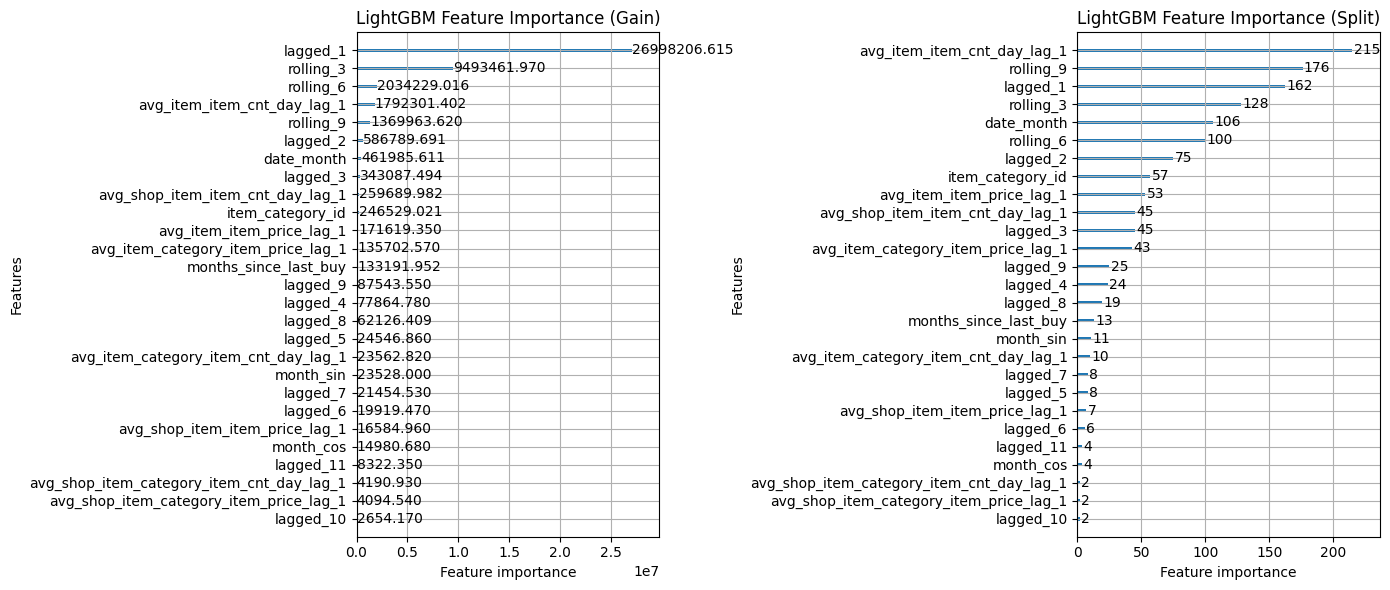

In [16]:
params = {
    'random_state': 42,
    'num_leaves': 28,
    'max_depth': 43,
    'learning_rate': 0.07188714405942678,
    'n_estimators': 50,
    'reg_alpha': 1.862771282197631,
    'reg_lambda': 0.6080693179624701,
    'colsample_bytree': 1.0,
    'subsample': 0.7,
    'min_child_samples': 236,
    'min_data_per_groups': 89
}

model = lgb.LGBMRegressor(**params, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
model.fit(X_train, train_target, eval_set=[(X_valid, valid_target)])

y_pred = model.predict(X_valid)
print(compute_metrics(valid_target.values, y_pred))
plot_feature_importance(model)

# Voting regressor - linear regression, decision tree, lightgbm

In [17]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin

class PreprocessingWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model, preprocessor):
        self.model = model
        self.preprocessor = preprocessor

    def fit(self, X, y):
        X_preprocessed = self.preprocessor.fit_transform(X)
        self.model.fit(X_preprocessed, y)
        return self

    def predict(self, X):
        X_preprocessed = self.preprocessor.transform(X)
        return self.model.predict(X_preprocessed)

lgbm_model = lgb.LGBMRegressor(**params, boosting_type='gbdt', n_jobs=-1, metric='rmse', objective='regression')
lr_pipeline = PreprocessingWrapper(LinearRegression(), preprocessor)
decision_tree_pipeline = PreprocessingWrapper(DecisionTreeRegressor(max_depth=10), preprocessor)

voting_model = VotingRegressor([("lgbm", lgbm_model), ("lr", lr_pipeline), ("tree", decision_tree_pipeline)], n_jobs=-1)
voting_model.fit(X_train, train_target.values)
y_pred = voting_model.predict(X_valid).clip(0, 20)
compute_metrics(valid_target.values, y_pred)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.409717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 21137776, number of used features: 29
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


{'rmse': 0.40591974642218004,
 'r2': 0.3606291081356743,
 'mae': 0.06947419269601868}

# Stacking regressor - Light GBM, Linear Regression, Decision Tree + linear regression as meta regressor

In [19]:
from sklearn.ensemble import StackingRegressor

lgbm_model = lgb.LGBMRegressor(**params, boosting_type='gbdt', metric='rmse', objective='regression')
lr_pipeline = PreprocessingWrapper(LinearRegression(), preprocessor)
decision_tree_pipeline = PreprocessingWrapper(DecisionTreeRegressor(max_depth=10), preprocessor)

stacking_model = StackingRegressor(
    estimators=[("lgbm", lgbm_model), ("lr", lr_pipeline), ("tree", decision_tree_pipeline)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train, train_target)
y_pred = stacking_model.predict(X_valid).clip(0, 20)
compute_metrics(valid_target.values, y_pred)

python(82232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.365788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3208
[LightGBM] [Info] Number of data points in the train set: 21137776, number of used features: 29
[LightGBM] [Info] Start training from score 0.084545
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 16910220, number of used features

{'rmse': 0.39139411394282486,
 'r2': 0.4055695014456494,
 'mae': 0.061088148028040606}

In [20]:
stacking_model.final_estimator_.coef_

array([ 0.73555815, -0.03240687,  0.34195504])

In [ ]:
train_test_split[train_test_split.set_index(['shop_id', 'item_id']).index.isin(lst_plot_report)]

In [ ]:
lst_plot_report = [(29, 5036), (16, 4678), (44, 14127), (24, 20253), (7, 5551), (39, 18454)]
df_plot_report = train_test_split[train_test_split.set_index(['shop_id', 'item_id']).index.isin(lst_plot_report)]
df_plot_report = df_plot_report.assign(pred=model.predict(df_plot_report.drop(columns=cols_to_drop)))

In [ ]:
plot_timeseries(train_test_split.assign(pred=model.predict(train_test_split.drop(cols_to_drop, axis=1))), plt_rows=30, plt_cols=2, rand=True, pred_col='pred')

In [ ]:
plot_timeseries(df_plot_report, plt_rows=3, plt_cols=2, rand=False, pred_col='pred', save_path='assets/plots/lgbm_preds.png')
